## Graph Convolutions For SIDER

Featurization=ConvMolFeaturizer

É utilizado com modelos GraphConvModel.

Alternativamente, também implementamos este modelo (GraphConvModel) usando layers do TensorGraph

In [1]:
"""
OFFSIDES dataset loader.
"""
from __future__ import division
from __future__ import unicode_literals

import os
import logging
import deepchem

logger = logging.getLogger(__name__)


def load_offsides(featurizer='ECFP', split='index', reload=True, K=4):
  logger.info("About to load ofssides dataset.")
  data_dir = deepchem.utils.get_data_dir()
  if reload:
    save_dir = os.path.join(data_dir, "offsides/" + featurizer + "/" + str(split))

  dataset_file = os.path.join("/home/mamonteiro/source-code/Project-LEI/OFFSIDES/", "offsides.csv.gz")


  dataset = deepchem.utils.save.load_from_disk(dataset_file)
  logger.info("Columns of dataset: %s" % str(dataset.columns.values))
  logger.info("Number of examples in dataset: %s" % str(dataset.shape[0]))
  OFFSIDES_tasks = dataset.columns.values[1:].tolist()

  if reload:
    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(
        save_dir)
    if loaded:
      return OFFSIDES_tasks, all_dataset, transformers

  # Featurize OFFSIDES dataset
  logger.info("About to featurize OFFSIDES dataset.")
  if featurizer == 'ECFP':
    featurizer = deepchem.feat.CircularFingerprint(size=1024)
  elif featurizer == 'GraphConv':
    featurizer = deepchem.feat.ConvMolFeaturizer()
  elif featurizer == 'Weave':
    featurizer = deepchem.feat.WeaveFeaturizer()
  elif featurizer == 'Raw':
    featurizer = deepchem.feat.RawFeaturizer()

  logger.info("OFFSIDES tasks: %s" % str(OFFSIDES_tasks))
  logger.info("%d tasks in total" % len(OFFSIDES_tasks))

  loader = deepchem.data.CSVLoader(
      tasks=OFFSIDES_tasks, smiles_field="smiles", featurizer=featurizer)
  dataset = loader.featurize(dataset_file)
  logger.info("%d datapoints in OFFSIDES dataset" % len(dataset))

  # Initialize transformers
  transformers = [
      deepchem.trans.BalancingTransformer(transform_w=True, dataset=dataset)
  ]
  logger.info("About to transform data")
  for transformer in transformers:
    dataset = transformer.transform(dataset)

  if split == None:
    return OFFSIDES_tasks, (dataset, None, None), transformers

  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'scaffold': deepchem.splits.ScaffoldSplitter(),
      'task': deepchem.splits.TaskSplitter()
  }
  splitter = splitters[split]
  if split == 'task':
    fold_datasets = splitter.k_fold_split(dataset, K)
    all_dataset = fold_datasets
  else:
    train, valid, test = splitter.train_valid_test_split(dataset)
    if reload:
      deepchem.utils.save.save_dataset_to_disk(save_dir, train, valid, test,
                                               transformers)
    all_dataset = (train, valid, test)
  return OFFSIDES_tasks, all_dataset, transformers


/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
deepchem.utils.get_data_dir()

'/tmp'

In [3]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import tensorflow as tf
import deepchem as dc
import pandas as pd
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel


# Load OFFSIDES Dataset

All MoleculeNet datasets are split into training, validation and test subsets following a 80/10/10 ratio. 

Different  splittings are recommended depending on each dataset's contents.

In [5]:
sider_tasks, sider_datasets, transformers = load_offsides(featurizer='GraphConv',reload=True)
train_dataset, valid_dataset, test_dataset = sider_datasets

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [6]:
len(train_dataset)

1141

In [7]:
sider_tasks

['Renal and urinary disorders',
 'Respiratory, thoracic and mediastinal disorders',
 'Skin and subcutaneous tissue disorders',
 'Congenital, familial and genetic disorders',
 'Hepatobiliary disorders',
 'Infections and infestations',
 'Cardiac disorders',
 'Ear and labyrinth disorders',
 'Investigations',
 'Vascular disorders',
 'Endocrine disorders',
 'Immune system disorders',
 'Product issues',
 'Blood and lymphatic system disorders',
 'Pregnancy, puerperium and perinatal conditions',
 'Surgical and medical procedures',
 'Psychiatric disorders',
 'Reproductive system and breast disorders',
 'Social circumstances',
 'Eye disorders',
 'Gastrointestinal disorders',
 'General disorders and administration site conditions',
 'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
 'Injury, poisoning and procedural complications',
 'Musculoskeletal and connective tissue disorders',
 'Metabolism and nutrition disorders',
 'Nervous system disorders']

Different classification and regress metrics are recommended based on previous works and dataset's contents:
          ROC-AUC:  Area Under Curve of Receiver Operating Characteristics
          PRC-AUC:  Area Under Curve of Precision Recall Curve
          RMSE: Root-Mean-Square Error
          MAE: Mean Absolute Error

In [8]:
num_epochs = [10,20,30,40,50,60]
losses = []
loss =0

model = GraphConvModel(
    27, batch_size=50, mode='classification')

In [9]:
for i in num_epochs:
    # Set nb_epoch=10 for better results.
    loss = model.fit(train_dataset, nb_epoch=i)
    print("Epoch %d loss: %f" % (i, loss))
    losses.append(loss)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 10 loss: 778.136019
Epoch 20 loss: 633.278606
Epoch 30 loss: 384.433875
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Epoch 40 loss: 219.738846
Epoch 50 loss: 131.713163
Epoch 60 loss: 79.090283


In [10]:
import matplotlib.pyplot as plot

plot.figure(figsize=(10,7))
plot.ylabel("Loss")
plot.xlabel("Epoch")
x = num_epochs
y = losses
plot.scatter(x, y)
plot

<module 'matplotlib.pyplot' from '/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [11]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

print("Evaluating model")
train_scores_1 = model.evaluate(train_dataset, [metric], transformers)
print("Training ROC-AUC Score: %f" % train_scores_1["mean-roc_auc_score"])


Evaluating model
computed_metrics: [0.9991558841651262, 0.994038627336836, 1.0, 0.9994199421260439, 0.9966060164968462, 0.99657009705355, 0.9977074002985711, 1.0, 0.9916282493317321, 0.9984037056174799, 1.0, 0.9915457648815873, 0.9999915810033759, 1.0, 0.999067105036727, 0.997511766694404, 0.9964418087472202, 0.999889497212316, 0.9978777367498415, 0.9946371538306045, 0.9962798129800395, 0.9978846218010744, 1.0, 0.9998490979754491, 0.998501872659176, 0.9965410685805423, 0.9985944191186629]
Training ROC-AUC Score: 0.997709


In [12]:
valid_scores_1 = model.evaluate(valid_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % valid_scores_1["mean-roc_auc_score"])

computed_metrics: [0.6538765822784811, 0.5636492220650636, 0.7816901408450705, 0.6117552978808476, 0.6265965439519159, 0.6829573934837093, 0.7148394241417497, 0.6274576271186441, 0.549645390070922, 0.6056670602125147, 0.6475929054054055, 0.6143250688705235, 0.5552345938375349, 0.5535569105691056, 0.6734513274336283, 0.6528462572837292, 0.5685285433070866, 0.6569086651053864, 0.6686046511627907, 0.6071235833783054, 0.6493023255813953, 0.678245766391663, 0.6720737913486006, 0.6209710322317421, 0.7126848946660691, 0.6851145038167938, 0.6221227621483376]
Validation ROC-AUC Score: 0.639142


In [13]:
test_scores_1 = model.evaluate(test_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % test_scores_1["mean-roc_auc_score"])

computed_metrics: [0.701592167721519, 0.6464194373401535, 0.5274822695035462, 0.5962745098039215, 0.7150635208711433, 0.6412131519274377, 0.7456938976377953, 0.5926704014939309, 0.6056689342403627, 0.6699921752738655, 0.6701183431952663, 0.6572916666666666, 0.6484745762711863, 0.6171802054154996, 0.6574728901461574, 0.6616222760290558, 0.6503267973856209, 0.5546218487394958, 0.6717641843971631, 0.7105139085337104, 0.5790273556231003, 0.6607507139942881, 0.5108796296296296, 0.6069410815173526, 0.6436058700209644, 0.684375, 0.6432913590968301]
Validation ROC-AUC Score: 0.639642


In [14]:
num_epochs = [60,70,80,90]
losses = []

model = GraphConvModel(
    len(sider_tasks), batch_size=50, mode='classification')
# Set nb_epoch=10 for better results.


In [15]:

for i in num_epochs:
    # Set nb_epoch=10 for better results.
    loss = model.fit(train_dataset, nb_epoch=10)
    print("Epoch %d loss: %f" % (i, loss))
    losses.append(loss)

Epoch 60 loss: 775.304345
Epoch 70 loss: 666.987900
Epoch 80 loss: 576.970132
Epoch 90 loss: 486.467053


<module 'matplotlib.pyplot' from '/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/matplotlib/pyplot.py'>

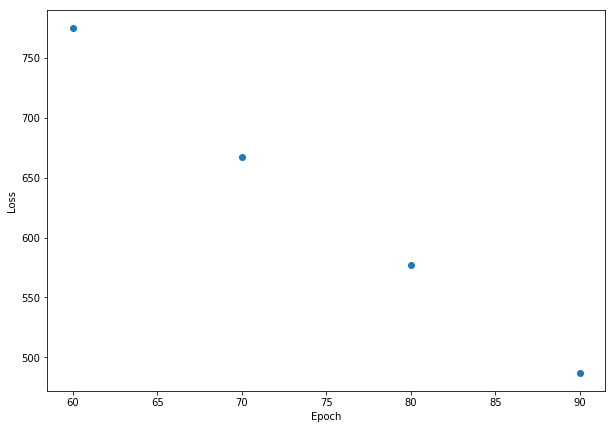

In [16]:
import matplotlib.pyplot as plot

plot.figure(figsize=(10,7))
plot.ylabel("Loss")
plot.xlabel("Epoch")
x = num_epochs
y = losses
plot.scatter(x, y)
plot

In [17]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

print("Evaluating model")
train_scores_2 = model.evaluate(train_dataset, [metric], transformers)
print("Training ROC-AUC Score: %f" % train_scores_2["mean-roc_auc_score"])



Evaluating model
computed_metrics: [0.8984134319162045, 0.8497019313668418, 0.9994370954123276, 0.8685015391308359, 0.9138403687530325, 0.874690582829434, 0.9396605207545707, 0.9325009754194304, 0.8293999147716267, 0.9148335424817302, 0.9245156482861401, 0.8896771211151411, 0.9516202359002854, 0.9435998586905323, 0.9030332672155349, 0.9001407452673185, 0.918890536199654, 0.9359334974132303, 0.8475215396665547, 0.85582979583586, 0.8907931568389662, 0.8736945714190384, 0.9689373046515903, 0.8778155546111346, 0.8869097451714768, 0.9258971291866029, 0.8574112446470508]
Training ROC-AUC Score: 0.902711


In [18]:
valid_scores_2 = model.evaluate(valid_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % valid_scores_2["mean-roc_auc_score"])

computed_metrics: [0.6698971518987342, 0.6027817067421027, 0.6830985915492958, 0.5997600959616154, 0.7250187828700225, 0.5791979949874686, 0.5869324473975637, 0.5833898305084746, 0.5483156028368794, 0.6182605273514364, 0.6297860360360359, 0.5633608815426998, 0.5738795518207283, 0.6252032520325204, 0.6327433628318584, 0.7014791573285521, 0.6299212598425197, 0.7029664324746292, 0.5469767441860465, 0.5914732865623313, 0.6109302325581395, 0.6576204950065132, 0.7442748091603053, 0.6301509587923296, 0.6694307485432542, 0.727735368956743, 0.5752344416027281]
Validation ROC-AUC Score: 0.629993


In [19]:
test_scores_2 = model.evaluate(test_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % test_scores_2["mean-roc_auc_score"])

computed_metrics: [0.7132120253164557, 0.676150895140665, 0.38652482269503546, 0.5660784313725489, 0.6999395039322445, 0.6272108843537414, 0.7599655511811023, 0.6013071895424836, 0.6503401360544218, 0.6809467918622848, 0.5853057199211045, 0.6166666666666667, 0.6894915254237288, 0.496265172735761, 0.6185761433286185, 0.6606133979015335, 0.7259570494864612, 0.5611577964519141, 0.6354166666666667, 0.6824611032531824, 0.6198436821537125, 0.7319461444308446, 0.41203703703703703, 0.5623486682808717, 0.5532494758909853, 0.6880208333333333, 0.6397090751194094]
Validation ROC-AUC Score: 0.623731


In [20]:
type(test_scores_2)
test_scores_2['mean-roc_auc_score']

0.6237311996123265

[(0.55, 0.6716238733740536)]

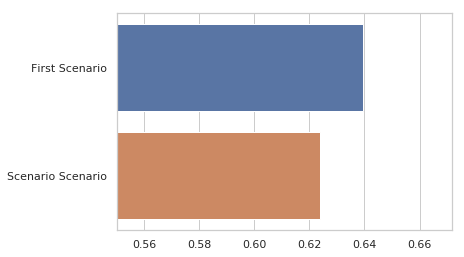

In [21]:
import seaborn as sns

sns.set(style="whitegrid")
ax = sns.barplot(x=[test_scores_1['mean-roc_auc_score'],test_scores_2['mean-roc_auc_score']],
                 y=['First Scenario','Scenario Scenario'])
ax.set(xlim=(0.55, None))

In [22]:
# Hiperparameters permitidos pelo deepchem e os valores que são utilizados por defeito
#/home/mamonteiro/source-code/knowledge-base/deepchem/deepchem/molnet/preset_hyper_parameters.py

In [23]:
params_dict = {'batch_size' : [32,64,128,256],
               'nb_epoch': [40,100,200],
               'learning_rate': [0.0005,0.5,0.75,1],
               'n_filters': [32,64,128],
               'n_fully_connected_nodes' : [32,64,128]
              }

In [ ]:
params_dict = {'batch_size' : [32],
               'nb_epoch': [10,20,30,40,50,60],
               'learning_rate': [0.0005,0.5],
               'n_filters': [32,64],
               'n_fully_connected_nodes' : [32,64]
              }

In [ ]:
len(train_dataset)

In [ ]:
n_features = len(train_dataset)

def model_builder(model_params, model_dir):
    model = GraphConvModel(
            len(sider_tasks), mode='classification',**model_params)
    
    return model



In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
   params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/48
hyperparameters: {'batch_size': 32, 'nb_epoch': 10, 'learning_rate': 0.0005, 'n_filters': 32, 'n_fully_connected_nodes': 32}
computed_metrics: [0.7223101265822784, 0.5115511551155116, 0.30281690140845074, 0.5641743302678928, 0.6870773854244928, 0.5606516290726817, 0.7032115171650055, 0.5972881355932204, 0.568927304964539, 0.5643447461629281, 0.5436373873873874, 0.3939393939393939, 0.5591736694677871, 0.6292682926829268, 0.5920353982300884, 0.6645002241147467, 0.6333661417322834, 0.6010928961748634, 0.6055813953488373, 0.6654074473826227, 0.6053488372093023, 0.5894485453755971, 0.7436386768447838, 0.5338637290901672, 0.6779471089197668, 0.6208651399491094, 0.4887041773231032]
Model 1/48, Metric mean-roc_auc_score, Validation set 0: 0.590006
	best_validation_score so far: 0.590006
Fitting model 2/48
hyperparameters: {'batch_size': 32, 'nb_epoch': 10, 'learning_rate': 0.0005, 'n_filters': 32, 'n_fully_connected_nodes': 64}
computed_metrics: [0.6784018987341773, 0.489627

computed_metrics: [0.7062895569620253, 0.5308816595945309, 0.8169014084507042, 0.5981607357057177, 0.6964688204357625, 0.524561403508772, 0.6389811738648947, 0.6467796610169492, 0.5538563829787234, 0.6328217237308147, 0.5864301801801802, 0.6019283746556474, 0.6260504201680672, 0.6512195121951219, 0.6188790560471977, 0.6761541909457642, 0.6545275590551181, 0.6768149882903981, 0.5941860465116279, 0.617916891527253, 0.6099999999999999, 0.6504559270516718, 0.6723918575063613, 0.5707874337005303, 0.6718960107575079, 0.7118320610687023, 0.5411338448422847]
Model 12/48, Metric mean-roc_auc_score, Validation set 11: 0.632530
	best_validation_score so far: 0.632530
Fitting model 13/48
hyperparameters: {'batch_size': 32, 'nb_epoch': 20, 'learning_rate': 0.5, 'n_filters': 32, 'n_fully_connected_nodes': 32}
computed_metrics: [0.5361451740506329, 0.5736680810938237, 0.5, 0.5499300279888044, 0.5979526671675431, 0.4800751879699248, 0.5985603543743079, 0.5922033898305085, 0.5278147163120568, 0.5199724

In [ ]:
best_dnn

In [ ]:
best_hyperparams

In [ ]:
all_results

In [ ]:
###AQUI

#(32, 40, 0.0005, 64, 32)

#'batch_size' : [32,64,128,256],
#'nb_epoch': [40,100,200],
#'learning_rate': [0.0005,0.5,0.75,1],
#'n_filters': [32,64,128],
#'n_fully_connected_nodes' : [32,64,128]

#model=model_builder(params_dict,params_dict)

#model =GraphConvModel(dense_layer_size=128, dropout=[0.0, 0.0, 0.0],
#               graph_conv_layers=[64, 64], mode='classification', n_classes=2,
#               n_tasks=27, number_atom_features=75, uncertainty=False)


model.fit(train_dataset,batch_size=32,nb_epoch=30,learning_rate=0.0005,n_filters=64,n_fully_connected_nodes=32)

In [ ]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

print("Evaluating model")
train_scores_3 = model.evaluate(train_dataset, [metric], transformers)
print("Training ROC-AUC Score: %f" % train_scores_3["mean-roc_auc_score"])


In [ ]:
valid_scores_3 = model.evaluate(valid_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % valid_scores_3["mean-roc_auc_score"])

In [ ]:
test_scores_3 = model.evaluate(test_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % test_scores_3["mean-roc_auc_score"])

In [ ]:
import seaborn as sns


sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.set(style="whitegrid")
ax = sns.barplot(x=[test_scores_1['mean-roc_auc_score'],test_scores_2['mean-roc_auc_score'],test_scores_2['mean-roc_auc_score']],
                 y=['First Scenario','Scenario Scenario','Third Scenario'])
ax.set(xlim=(0.55, None))

# Another Implementation GraphConvModel

TensorGraph - Simplicity is Beauty
TensorGraph is a simple, lean, and clean framework on TensorFlow for building any imaginable models.



What’s going on under the hood? 

Now we will build GraphConvModel ourselves.

The first step is to create a TensorGraph object. 
This object will hold the “computational graph” that defines the computation that a graph convolutional network will perform.


In [ ]:
from deepchem.models.tensorgraph.tensor_graph import TensorGraph
from deepchem.models.tensorgraph.layers import Dense, BatchNorm,GraphConv
from deepchem.models.tensorgraph.layers import GraphPool, GraphGather,Dropout
import keras
import tensorflow as tf


In [ ]:
tg = TensorGraph(use_queue=False)

In [ ]:
from deepchem.models.tensorgraph.layers import Feature

atom_features = Feature(shape=(None, 75))
degree_slice = Feature(shape=(None, 2), dtype=tf.int32)
membership = Feature(shape=(None,), dtype=tf.int32)

deg_adjs = []
for i in range(0, 10 + 1):
    deg_adj = Feature(shape=(None, i + 1), dtype=tf.int32)
    deg_adjs.append(deg_adj)

In [ ]:
# ver mais um atomo na 

tiro a camada de dropout e verifico se esta em overfitting

In [ ]:
batch_size = 50

gc1 = GraphConv(64,activation_fn=tf.nn.relu,in_layers=[atom_features, degree_slice, membership] + deg_adjs)
dropout_1 = Dropout(dropout_prob=0.5, in_layers=[gc1])
batch_norm1 = BatchNorm(in_layers=[dropout_1])
gp1 = GraphPool(in_layers=[batch_norm1, degree_slice, membership] + deg_adjs)

gc2 = GraphConv(64,activation_fn=tf.nn.relu,in_layers=[gp1, degree_slice, membership] + deg_adjs)
batch_norm2 = BatchNorm(in_layers=[gc2])
gp2 = GraphPool(in_layers=[batch_norm2, degree_slice, membership] + deg_adjs)

gc3 = GraphConv(64,activation_fn=tf.nn.relu,in_layers=[gp1, degree_slice, membership] + deg_adjs)
batch_norm3 = BatchNorm(in_layers=[gc3])
gp3 = GraphPool(in_layers=[batch_norm3, degree_slice, membership] + deg_adjs)

dense = Dense(out_channels=128, activation_fn=tf.nn.relu, in_layers=[gp3])
batch_norm4 = BatchNorm(in_layers=[dense])

readout = GraphGather(batch_size=batch_size,activation_fn=tf.nn.tanh,in_layers=[batch_norm4, degree_slice, membership] + deg_adjs)

In [ ]:
from deepchem.models.tensorgraph.layers import Dense, SoftMax, \
    SoftMaxCrossEntropy, WeightedError, Stack

from deepchem.models.tensorgraph.layers import Label, Weights

costs = []
labels = []
for task in range(len(sider_tasks)):
    classification = Dense(out_channels=2, activation_fn=None, in_layers=[readout])

    softmax = SoftMax(in_layers=[classification])
    tg.add_output(softmax)

    label = Label(shape=(None, 2))
    labels.append(label)
    cost = SoftMaxCrossEntropy(in_layers=[label, classification])
    costs.append(cost)
    
all_cost = Stack(in_layers=costs, axis=1)
weights = Weights(shape=(None, len(sider_tasks)))
loss = WeightedError(in_layers=[all_cost, weights])
tg.set_loss(loss)

In [ ]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

def data_generator(dataset, epochs=1, predict=False, pad_batches=True):
    for epoch in range(epochs):
        if not predict:
            print('Starting epoch %i' % epoch)
        for ind, (X_b, y_b, w_b, ids_b) in enumerate(
            dataset.iterbatches(batch_size, pad_batches=pad_batches, deterministic=True)):
            d = {}

            for index, label in enumerate(labels):
                d[label] = to_one_hot(y_b[:, index])
            d[weights] = w_b
            multiConvMol = ConvMol.agglomerate_mols(X_b)
            d[atom_features] = multiConvMol.get_atom_features()
            d[degree_slice] = multiConvMol.deg_slice
            d[membership] = multiConvMol.membership
            for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
                d[deg_adjs[i - 1]] = multiConvMol.get_deg_adjacency_lists()[i]
            yield d

In [ ]:
# Epochs set to 1 to render tutorials online.
# Set epochs=10 for better results.
tg.fit_generator(data_generator(train_dataset, epochs=60))

In [ ]:
# Training dataset

In [ ]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

def reshape_y_pred(y_true, y_pred):
    """
    TensorGraph.Predict returns a list of arrays, one for each output
    We also have to remove the padding on the last batch
    Metrics taks results of shape (samples, n_task, prob_of_class)
    """
    n_samples = len(y_true)
    retval = np.stack(y_pred, axis=1)
    return retval[:n_samples]


In [ ]:
print("Evaluating model")
train_predictions = tg.predict_on_generator(data_generator(train_dataset, predict=True))
train_predictions = reshape_y_pred(train_dataset.y, train_predictions)
train_scores_4 = metric.compute_metric(train_dataset.y, train_predictions, train_dataset.w)

print("----------------")
print("Training ROC-AUC Score: %f" % train_scores_4)


In [ ]:
# Validation Dataset

In [ ]:
valid_predictions = tg.predict_on_generator(data_generator(valid_dataset, predict=True))
valid_predictions = reshape_y_pred(valid_dataset.y, valid_predictions)
valid_scores_4 = metric.compute_metric(valid_dataset.y, valid_predictions, valid_dataset.w)
print("Valid ROC-AUC Score: %f" % valid_scores_4)


In [ ]:
# Test Dataset

In [ ]:
test_predictions = tg.predict_on_generator(data_generator(test_dataset, predict=True))
test_predictions = reshape_y_pred(test_dataset.y, test_predictions)
test_scores_4 = metric.compute_metric(test_dataset.y, test_predictions, test_dataset.w)
print("Test  ROC-AUC Score: %f" % test_scores_4)


# Comparision of Results with MoleculeNet results

In [ ]:
import seaborn as sns


sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.set(style="whitegrid")
ax = sns.barplot(x=[test_scores_1['mean-roc_auc_score'],test_scores_2['mean-roc_auc_score'],test_scores_3['mean-roc_auc_score'],test_scores_4],
                 y=['First Scenario','Scenario Scenario','Third Scenario','Modelo Desenvolvido Raiz'])
ax.set(xlim=(0.55, None))

In [ ]:
print(test_scores_1['mean-roc_auc_score'])

print(test_scores_2['mean-roc_auc_score'])
print(test_scores_3['mean-roc_auc_score'])
print(test_scores_4)

In [ ]:
import seaborn as sns

sns.set(style="whitegrid")
ax = sns.barplot(x=[test_scores_1['mean-roc_auc_score'],test_scores_2['mean-roc_auc_score'],test_scores_3['mean-roc_auc_score'],test_scores_4['mean-roc_auc_score']],
                 y=['First Scenario','Scenario Scenario','Third Scenario','fourth Scenario'])
ax.set(xlim=(0.55, None))